In [1]:
import uproot
import ROOT

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

Welcome to JupyROOT 6.14/00


In [5]:
import numpy as np

def extract_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    ROOT.gPad.Update()
    
    tot = eff.GetTotalHistogram()
    nBins = tot.GetNbinsX()
    xx = np.array([tot.GetXaxis().GetBinCenter(i)                 for i in range(1, nBins+1)])
    yy = np.array([eff.GetEfficiency(eff.GetGlobalBin(i))         for i in range(1, nBins+1)])
    yl = np.array([eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)) for i in range(1, nBins+1)])
    yu = np.array([eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i))  for i in range(1, nBins+1)])
    
    return {'x': xx,
            'y': yy,
            'yerr': np.array([yu, yl])}

## Trigger `HLT_DoubleL2Mu23NoVtx_2Cha`

In [2]:
from collections import OrderedDict

DL2Mu23T = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['TRIG_dsa_DL2Mu23/trigEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root')   ['TRIG_dsa_DL2Mu23/trigEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root')    ['TRIG_dsa_DL2Mu23/trigEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root')     ['TRIG_dsa_DL2Mu23/trigEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root')     ['TRIG_dsa_DL2Mu23/trigEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root')     ['TRIG_dsa_DL2Mu23/trigEffiForMuTrack']     
})

In [3]:
DL2Mu23T[1].keys()

[b'fired', b'pt', b'eta', b'phi']

Text(0.5,0,'$p_{T}$ [GeV]')

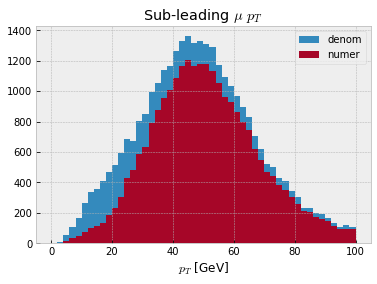

In [19]:
t = DL2Mu23T[1]
pt = t.array('pt')
start = pt.starts
denom = pt.content[start+1]
fd = t.array('fired')
numer = pt.content[start[fd]+1]
fig,ax = plt.subplots()
ax.hist(denom, bins=50, range=(0,100), label='denom')
ax.hist(numer, bins=50, range=(0,100), label='numer')
ax.legend(loc='best')
ax.set_title('Sub-leading $\mu$ $p_{T}$')
ax.set_xlabel('$p_{T}$ [GeV]')

### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha` Efficiency as a function of sub-leading $\mu$ $p_{T}$

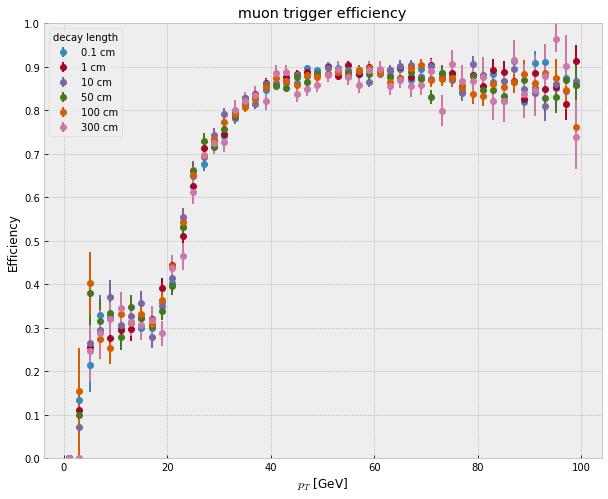

In [7]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23T.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha` Efficiency as a function of sub-leading $\mu$ $\eta$

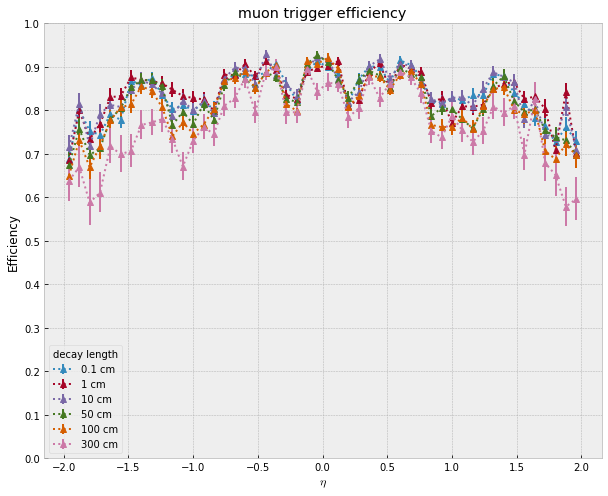

In [9]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23T.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2., 2.)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2., 2.)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

## Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched`

In [10]:
DL2Mu23NoL2T = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['TRIG_dsa_DL2Mu23NoL2/trigEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root')   ['TRIG_dsa_DL2Mu23NoL2/trigEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root')    ['TRIG_dsa_DL2Mu23NoL2/trigEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root')     ['TRIG_dsa_DL2Mu23NoL2/trigEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root')     ['TRIG_dsa_DL2Mu23NoL2/trigEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root')     ['TRIG_dsa_DL2Mu23NoL2/trigEffiForMuTrack']     
})

### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched` Efficiency as a function of sub-leading $\mu$ $p_{T}$

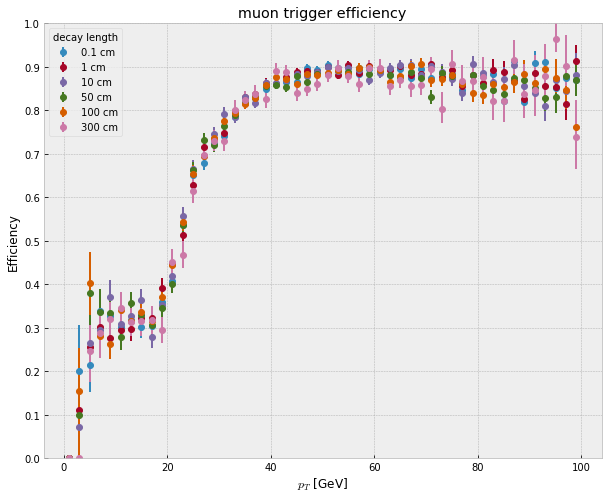

In [11]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23NoL2T.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched` Efficiency as a function of sub-leading $\mu$ $\eta$

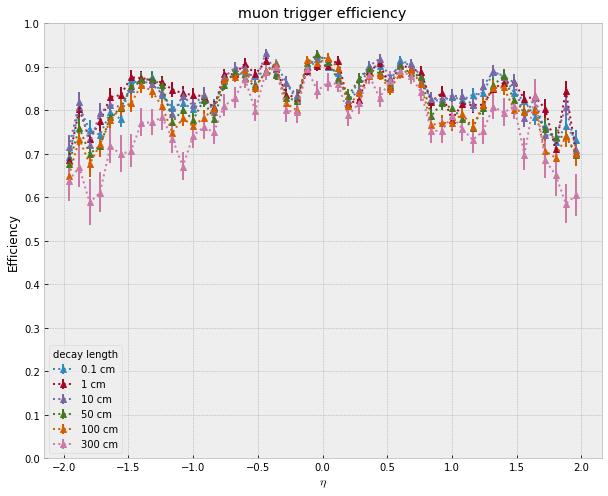

In [12]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23NoL2T.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2., 2.)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2., 2.)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

## Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed`

In [13]:
DL2Mu23CosmicT = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['TRIG_dsa_DL2Mu23CosmicSeed/trigEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root')   ['TRIG_dsa_DL2Mu23CosmicSeed/trigEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root')    ['TRIG_dsa_DL2Mu23CosmicSeed/trigEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root')     ['TRIG_dsa_DL2Mu23CosmicSeed/trigEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root')     ['TRIG_dsa_DL2Mu23CosmicSeed/trigEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root')     ['TRIG_dsa_DL2Mu23CosmicSeed/trigEffiForMuTrack']     
})

### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed` Efficiency as a function of sub-leading $\mu$ $p_{T}$

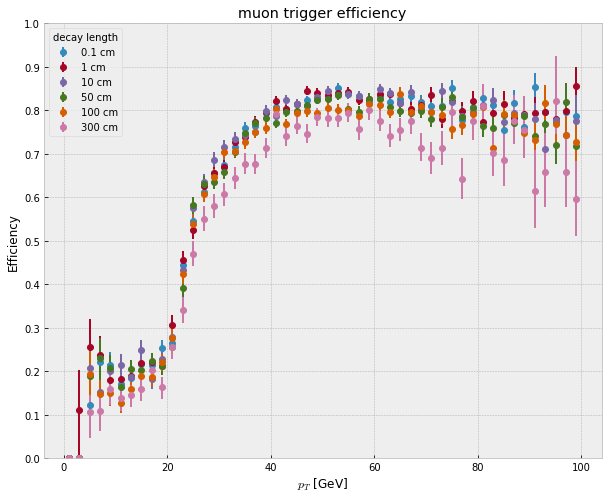

In [14]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23CosmicT.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed` Efficiency as a function of sub-leading $\mu$ $\eta$

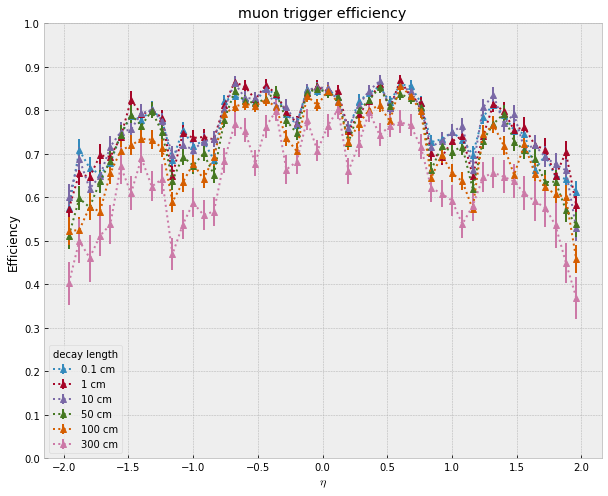

In [15]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23CosmicT.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2., 2.)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2., 2.)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

## Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched`

In [16]:
DL2Mu23CosmicNoL2T = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['TRIG_dsa_DL2Mu23CosmicSeedNoL2/trigEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root')   ['TRIG_dsa_DL2Mu23CosmicSeedNoL2/trigEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root')    ['TRIG_dsa_DL2Mu23CosmicSeedNoL2/trigEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root')     ['TRIG_dsa_DL2Mu23CosmicSeedNoL2/trigEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root')     ['TRIG_dsa_DL2Mu23CosmicSeedNoL2/trigEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root')     ['TRIG_dsa_DL2Mu23CosmicSeedNoL2/trigEffiForMuTrack']     
})

### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched` Efficiency as a function of sub-leading $\mu$ $p_{T}$

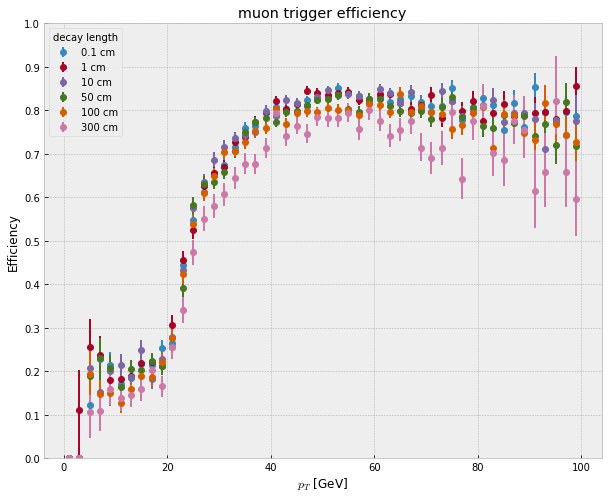

In [17]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23CosmicNoL2T.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched` Efficiency as a function of sub-leading $\mu$ $\eta$

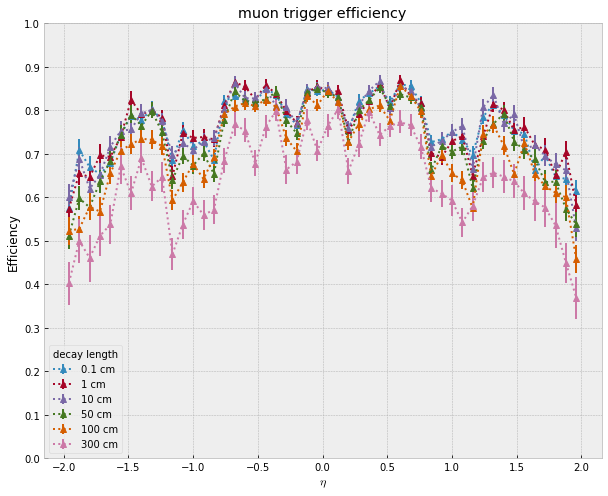

In [18]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23CosmicNoL2T.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2., 2.)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2., 2.)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')